# Regularizing a Morphological Layer for Deep Learning

## Classical Regularization

Regularization has been used for decades prior to the advent of deep learning in linear models such as linear regression and logistic regression. Regularization techniques work by limiting the capacity of models by adding a parameter norm penalty to the objective function. 

\begin{equation}
\hat{\theta} =\arg\min_{\theta} \sum_{i=0}^{N} \mathit{loss}(y_k,\phi_{f;\theta}(x_k)) + \lambda \Omega(\theta) 
\end{equation}

In the case of:
1. **{index}`Ridge regularization`** or **{index}`Tikhonov regularization`**  or$L_2$ regularization uses the term $\Omega(\theta)$ is given by $\Omega(\theta)=||\theta||^2_2$,
2. **{index}`Lasso regularization`** or $L_1$ regularization uses the term $\Omega(\theta)$ is given by $\Omega(\theta)=|\theta|_1$,
3. **{index}`Elastic net regularization`** or $L_1L_2$ regularization uses the term $\Omega(\theta)$ is given by $\lambda\Omega(\theta)=\lambda_1||\theta||^2_2 + \lambda_2 |\theta|_1$,

## Regularization for morphological layers


For morphological layers, the previous regularization do not make any sense due to the fact of the value 0 in a parameter is still important for a max-plus convolution. Accordingly, we regularize penalizing values with respecto to their distance to $-\infty$.

1. **{index}`L1Lattice`** regularization, the regularization term $\Omega(\theta)$ is given by $\Omega(\theta)=||\theta-\infty||^2_2$,
2. **{index}`L2Lattice`** or $L_1$ regularization, the regularization term $\Omega(\theta)$ is given by $\Omega(\theta)=|\theta-\infty|_1$,
3. **{index}`L1L2Lattice`** or $L_1L_2$ regularization, the regularization term $\Omega(\theta)$ is given by $\lambda\Omega(\theta)=\lambda_1||\theta-\infty||^2_2 + \lambda_2 |\theta-\infty|_1$

```{note}
Numerically, the value of $\infty$ is defined by the global variable MIN_LATT with the default value MIN_LATT=-1 
```


In [1]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
use_samples=1024

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

x_train=x_train[0:use_samples]
y_train=y_train[0:use_samples]

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1024, 28, 28, 1)
1024 train samples
10000 test samples


In [3]:
from morpholayers import *
from morpholayers.layers import *
from morpholayers.constraints import *
from morpholayers.regularizers import *

In [4]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Model

In [5]:
batch_size = 128
epochs = 100


In [6]:
nfilterstolearn=8
filter_size=5
regularizer_parameter=.002

In [7]:
from sklearn.metrics import classification_report,confusion_matrix
def get_model(layer0):
    xin=Input(shape=input_shape)
    xlayer=layer0(xin)
    x=MaxPooling2D(pool_size=(2, 2))(xlayer)
    x=Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x=MaxPooling2D(pool_size=(2, 2))(x)
    x=Flatten()(x)
    x=Dropout(0.5)(x)
    xoutput=Dense(num_classes, activation="softmax")(x)
    return Model(xin,outputs=xoutput), Model(xin,outputs=xlayer)

def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss by Epochs')
    plt.grid('on')
    plt.legend()
    plt.show()
    plt.plot(history.history['accuracy'],label='acc')
    plt.plot(history.history['val_accuracy'],label='val_acc')
    plt.grid('on')
    plt.title('Model Accuracy by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def plot_output_filters(model):
    fig=plt.figure()
    Z=model.predict(x_train[0:1,:,:,:])
    for i in range(Z.shape[3]):
        plt.subplot(2,Z.shape[3]/2,i+1)
        plt.imshow(Z[0,:,:,i],cmap='gray',vmax=Z.max(),vmin=Z.min())
        #plt.colorbar()
    fig.suptitle('Output of Learned Filters for an example')

def plot_filters(model):
    Z=model.layers[-1].get_weights()[0]
    fig=plt.figure()
    for i in range(Z.shape[3]):
        plt.subplot(2,Z.shape[3]/2,i+1)
        plt.imshow(Z[:,:,0,i],cmap='RdBu',vmax=Z.max(),vmin=Z.min())
    fig.suptitle('Learned Filters')
    
def see_results_layer(layer,lr=.001):
    modeli,modellayer=get_model(layer)
    modeli.summary()
    modeli.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(lr=lr), metrics=["accuracy"])
    historyi=modeli.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), 
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(patience=3,factor=.5)],verbose=0)
    Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
    y_pred = np.argmax(modeli.predict(x_test),axis=1)
    CM=confusion_matrix(Y_test, y_pred)
    print(CM)
    plt.imshow(CM,cmap='hot',vmin=0,vmax=1000)
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(Y_test, y_pred))
    plot_history(historyi)
    plot_filters(modellayer)
    plot_output_filters(modellayer)
    return historyi
    

### Example of Dilation Layer

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
dilation2d (Dilation2D)      (None, 24, 24, 8)         200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 32)        2336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0     

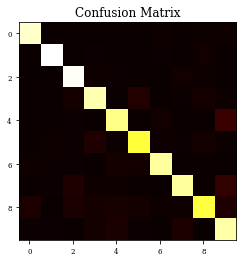

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.91      0.96      0.93      1032
           3       0.91      0.91      0.91      1010
           4       0.91      0.90      0.90       982
           5       0.91      0.90      0.90       892
           6       0.95      0.94      0.95       958
           7       0.93      0.88      0.90      1028
           8       0.92      0.83      0.87       974
           9       0.83      0.91      0.86      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



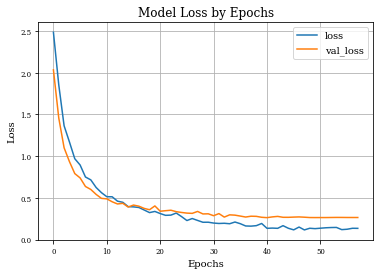

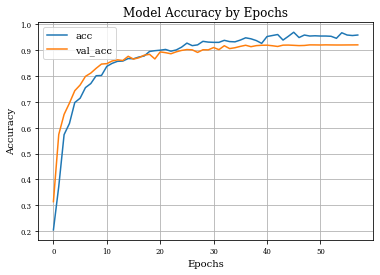

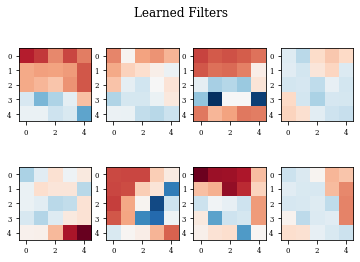

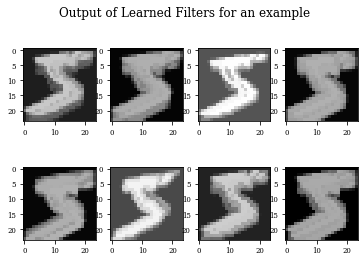

In [8]:
histDil=see_results_layer(Dilation2D(nfilterstolearn, padding='valid',kernel_size=(filter_size, filter_size)),lr=.01)

### Example of Dilation Layer with Regularization

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
dilation2d_1 (Dilation2D)    (None, 24, 24, 8)         200       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        2336      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0   

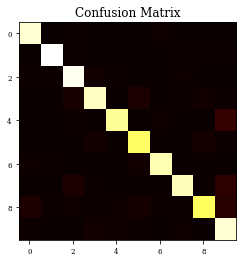

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.95      0.94      1032
           3       0.94      0.93      0.94      1010
           4       0.96      0.91      0.94       982
           5       0.93      0.95      0.94       892
           6       0.97      0.96      0.97       958
           7       0.96      0.90      0.93      1028
           8       0.94      0.86      0.90       974
           9       0.84      0.95      0.89      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



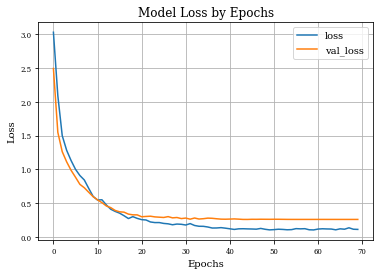

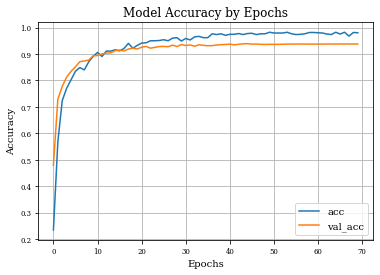

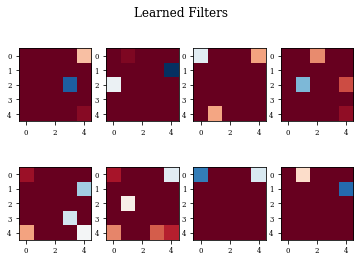

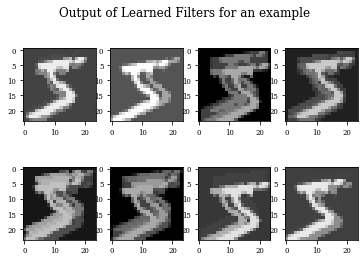

In [9]:
histDilReg=see_results_layer(Dilation2D(nfilterstolearn, padding='valid',kernel_size=(filter_size, filter_size),kernel_regularization=L1L2Lattice(l1=regularizer_parameter,l2=regularizer_parameter)),lr=.01)

In [21]:
from myst_nb import glue
a=np.round(max(histDil.history['accuracy']),4) 
b=np.round(max(histDilReg.history['accuracy']),4)
c=np.round(max(histDil.history['val_accuracy']),4)
d=np.round(max(histDilReg.history['val_accuracy']),4)
glue("BestDilation",a,display=False)
glue("BestRegDilation",b ,display=False)
glue("BestDilationVal",c,display=False)
glue("BestRegDilationVal",d,display=False)


Dilation layer obtains {glue:}`BestDilation` as best accuracy in comparison to {glue:}`BestRegDilation` for the regulirized dilation on training samples.

In validation samples, dilation layer has an accuracy of {glue:}`BestDilationVal` and the regularized version  {glue:}`BestRegDilationVal`

Ploting both curves of validation accuracy, we can see the goodness of regularization.

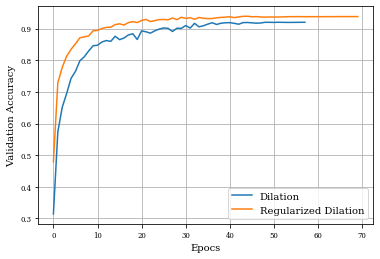

In [24]:
plt.plot(histDil.history['val_accuracy'],label='Dilation')
plt.plot(histDilReg.history['val_accuracy'],label='Regularized Dilation')
plt.xlabel('Epocs')
plt.ylabel('Validation Accuracy')
plt.grid()
plt.legend()
plt.show()